In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sn

In [3]:
df = pd.read_csv(r'games.csv')
df.head(3)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3


In [4]:
# удалим внутренний индекс, поскольку он никак нам не пригодится. 
df = df.drop(columns='id');

In [5]:
# проверим на нули
#TODO

Попробуем исключить ненужные признаки.

Например, *openind_name* - скорее всего избыточная информация, поскольку она (интуитивно) коррелирует с *opening_eco*. 

Пострроим корреляционную матрицу для числовых признаков

<AxesSubplot: >

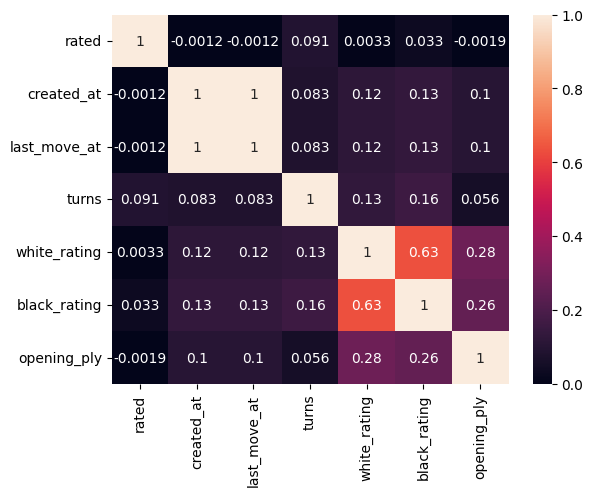

In [6]:
# Correlation Matrix formation
corr_matrix = df.corr(numeric_only = True);
#print(corr_matrix)
sn.heatmap(corr_matrix, annot=True)

Видим корреляцию 1 между *created_at* и *last_move_at*, значть безболезненно можем уделить один из этих признаков.

In [7]:
df = df.drop(columns='last_move_at');

Но помимо принаков, выраженных в числах, нам интересна коррелция между строковыми признаками. Исследлвание цвета, ников и типа игры пока отложим, поскольку корреляционные свойства этих столбцов не вызывают сомнений.

In [8]:
df['opening_name'].astype('category').cat.codes. corr(df['opening_eco'].astype('category').cat.codes)

0.029484289873009637

Видим очень низную корреляцию, но интуиция подсказыват, что все не так просто. Копнем глубже.

In [9]:
df_openings = df[['opening_name', 'opening_eco']]
df_openings = df_openings.sort_values (by = ['opening_name', 'opening_eco'])
# удалим одинаковые строки
df_openings = df_openings.drop_duplicates()
print(df_openings)

                             opening_name opening_eco
141                      Alekhine Defense         B02
424                      Alekhine Defense         B03
124                   Alekhine Defense #2         B03
9637                  Alekhine Defense #3         B03
4394   Alekhine Defense: Balogh Variation         B03
...                                   ...         ...
598    Zukertort Opening: Slav Invitation         A04
1070   Zukertort Opening: Tennison Gambit         A06
10761       Zukertort Opening: The Walrus         A04
5057        Zukertort Opening: Vos Gambit         A04
18548     Zukertort Opening: Wade Defense         A04

[1542 rows x 2 columns]


opening_name    1477
opening_eco      365
dtype: int64
df_len =  20058


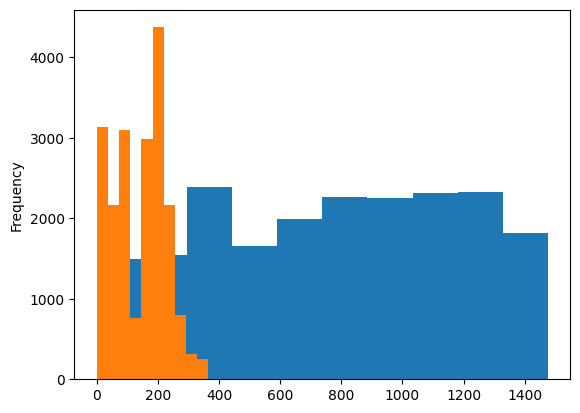

In [10]:
print(df[['opening_name', 'opening_eco']].nunique())
print('df_len = ', len(df))
ax = df['opening_name'].astype('category').cat.codes.plot.hist(bins=10)
ax = df['opening_eco'].astype('category').cat.codes.plot.hist(bins=10)
# opening_eco Ведет себя гораздо интереснее, чем почти равномерный opening_name
# к тому же на каждый opening_name приходится всего по 13 игр против 55 у opening_eco

Теперь хорошо видно, что признак *opening name* либо содердит более подробную информацию, чем *opening_eco*, либо один и тот же вариант признака назван по-разному.

Нам стоит избавиться от копий, похожих на *Alekhine Defense* - *Alekhine Defense №2*, поскольку это не несет никакой информации. Но с учетом того, что в шахматах огромное количество дебютов, размер выборки просто не позволит анализировать игры с точной идентификацией дебютов. Значит логично вообще избавиться от столбца *opening_name*. 

К тому же, поскольку *opening_name* однозначно определяет первые ходы в партии, а дальнейшие ходы нас не интересуют (ввиду сложности анализа без шахматного движка), прихнак *moves* смело удаляем тоже.

In [11]:
df = df.drop(columns=['opening_name', 'moves'])

In [12]:
df.columns

Index(['rated', 'created_at', 'turns', 'victory_status', 'winner',
       'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'opening_eco', 'opening_ply'],
      dtype='object')

Наконец проанализируем корреляцию признака, отвечающего за победу с другими признаками.

Для начала перечислим те признаки, которые нас особенно интересуют:
* Рейтинг победителя и проигравшего [*white_rating*, *black_rating*]
* Цвет фигур победителя (например, известно, что на высоком уровне цвет фигур приобретает больший вес)
* Число ходов в партии *turns*
* Число ходов, сделанных по дебюту
* Вариант завершения игры *victory_status*
* Тип контроля

In [13]:
print('Варианты завершения игры:', df['victory_status'].unique())
print('Число вариантов контроля', df['increment_code'].nunique())
print('Варианты числа ходов по дебюту', np.sort(df['opening_ply'].unique().tolist()))

Варианты завершения игры: ['outoftime' 'resign' 'mate' 'draw']
Число вариантов контроля 400
Варианты числа ходов по дебюту [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 24 28]


Построим гистограммы рейтингов

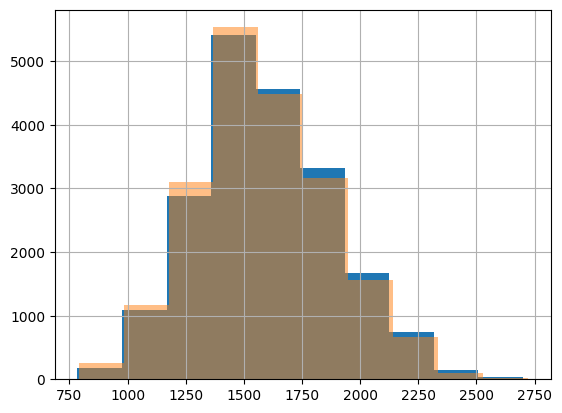

In [14]:
hist = df['white_rating'].hist()
hist = df['black_rating'].hist(alpha = 0.5)
x_train = df['black_rating'].tolist()


mean =  1588.8319872370128
std =  291.02887100586514


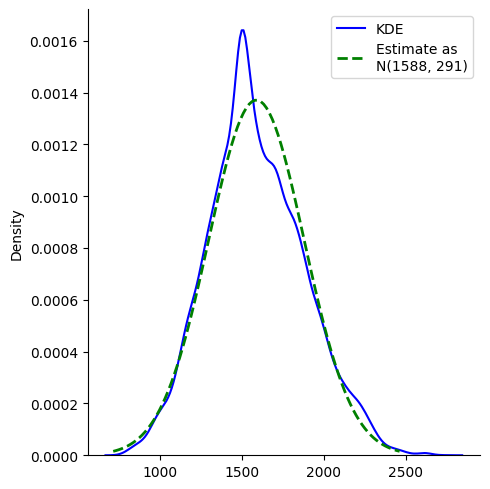

In [15]:
# Yормальное распределение? Ради прикола посчитаем выборочные μ, σ и ядерную оценку плотности KDE
from numpy.random import randn
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

ax = sns.displot(x_train, kind="kde", label = 'KDE', color = 'blue')
mu = np.mean(x_train)
print('mean = ', mu)
print('std = ', np.std(x_train))

variance = np.var(x_train)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax = plt.plot(x, stats.norm.pdf(x, mu, sigma), color = 'green', label = 'Estimate as \nN(' + str(int(mu)) + ', ' + str(int(sigma)) + ')', linestyle='--', linewidth = 2)
plt.legend()
plt.show()

Посморим, что происходит внутри вариантов контроля, поcкольку их получается слишком много

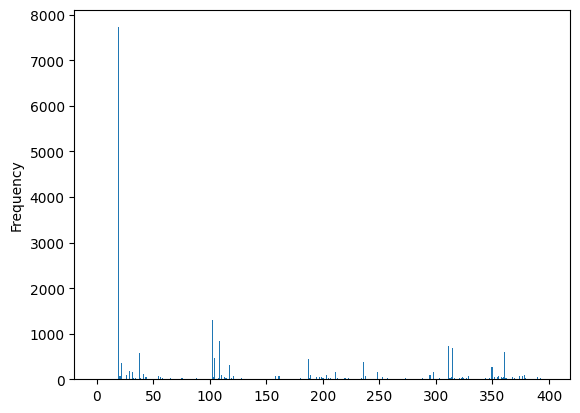

In [16]:
ax = df['increment_code'].astype('category').cat.codes.plot.hist(bins=400)
# или если перевести по-человечески

Избавимся от инкремента с учетом правил шахмат с фишеровским добавленем: x+y обозначает x минут на игру + y секунд каждый ход

In [17]:
increment_codes = df['increment_code'].tolist()
#turns = df['turns'].tolist()
new_t = [i.split('+') for i in increment_codes]
#increment_codes_modif = [ (int(new_t[i][0]) + int(new_t[i][1])*turns[i])  for i in range(len(turns))]
df['limit'] = [int(i[0]) for i in new_t]#increment_codes_modif
df['increment'] = [int(i[1]) for i in new_t]#increment_codes_modif

In [18]:
df[['limit', 'increment', 'increment_code']]

,limit,increment,increment_code
0,15,2,15+2
1,5,10,5+10
2,5,10,5+10
3,20,0,20+0
4,30,3,30+3
...,...,...,...
20053,10,10,10+10
20054,10,0,10+0
20055,10,0,10+0
20056,10,0,10+0


33
20058


[(10, 9456),
 (15, 3382),
 (5, 1795),
 (20, 936),
 (8, 924),
 (30, 746),
 (7, 661),
 (25, 322),
 (9, 261),
 (12, 225),
 (6, 176),
 (45, 158),
 (180, 154),
 (60, 103),
 (11, 98)]

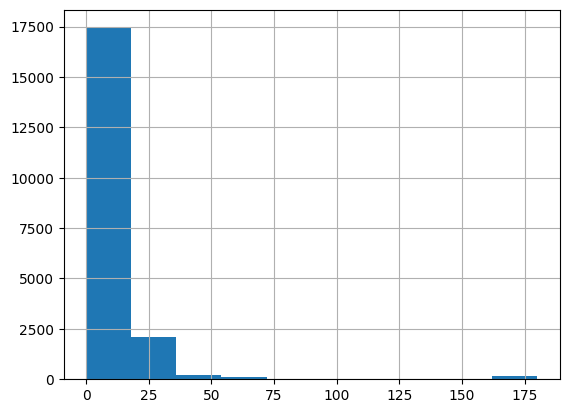

In [19]:
from collections import Counter
print(df['limit'].nunique())
print(len(df['limit'].tolist()))
hist = df['limit'].hist(bins = 10)
# и сразу все видно.

Counter(df['limit'].tolist()).most_common(15)

Как шахматист со стажем заявляю, что датасет сомнетельный, поскольку 90% шахматистов играют "bullit" 1+0
![title](https://r3.mt.ru/r5/photo29D5/20280393772-0/jpg/bp.jpeg)

In [20]:
df = df.drop(columns=['increment_code'])

[0.04736264831987237, 0.45403330342008175, 0.49860404826004584]


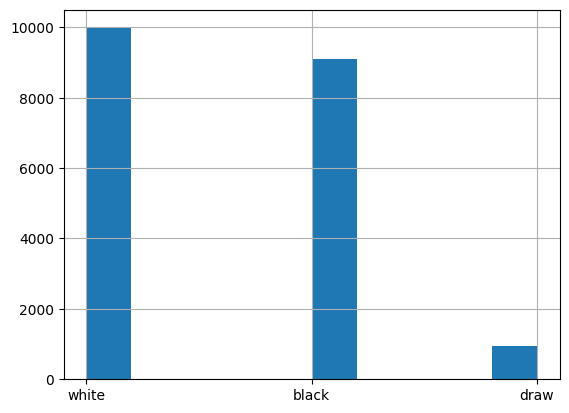

In [21]:
hist = df['winner'].hist()
Counter(df['winner'].tolist())

Nor = 10001 + 9107 + 950
freq = [950/Nor, 9107/Nor, 10001/Nor]
print(freq)

В результате на данный момент имеем

In [22]:
df

,rated,created_at,turns,victory_status,winner,white_id,white_rating,black_id,black_rating,opening_eco,opening_ply,limit,increment
0,False,1.504210e+12,13,outoftime,white,bourgris,1500,a-00,1191,D10,5,15,2
1,True,1.504130e+12,16,resign,black,a-00,1322,skinnerua,1261,B00,4,5,10
2,True,1.504130e+12,61,mate,white,ischia,1496,a-00,1500,C20,3,5,10
3,True,1.504110e+12,61,mate,white,daniamurashov,1439,adivanov2009,1454,D02,3,20,0
4,True,1.504030e+12,95,mate,white,nik221107,1523,adivanov2009,1469,C41,5,30,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,True,1.499791e+12,24,resign,white,belcolt,1691,jamboger,1220,A80,2,10,10
20054,True,1.499698e+12,82,mate,black,jamboger,1233,farrukhasomiddinov,1196,A41,2,10,0
20055,True,1.499698e+12,35,mate,white,jamboger,1219,schaaksmurf3,1286,D00,3,10,0
20056,True,1.499696e+12,109,resign,white,marcodisogno,1360,jamboger,1227,B07,4,10,0


**(1)**
 Классификация на основе таблицы игр

 Это не очень хороший путь, поскольку предполагается, что известна некоторая информация *об игре*, а *информация об игроках* сведена к минимуму, что в реальности бесполезно. Более того, предсказание без учета дополнительных признаков каждого даст очень слабый результат.

Для начала переведем строковые данные в численные и нормализуем данные

In [23]:
X = df
X['rated'] = [int(i) for i in df['rated'].tolist()]
X = X.replace({'winner' : { 'white' : 2, 'black' : 1, 'draw' : 0}}) # заменяем сроки из 'winner' на инт
X = X.replace({'victory_status' : { 'outoftime' : 3, 'resign' : 2, 'mate' : 1, 'draw' : 0}}) # заменяем сроки из 'victory_status' на инт
X = X.drop(columns=['white_id', 'black_id']) # удаляем ники пользователей, поскольку это не признак
ln = X['opening_eco'].nunique()

#Переходим от шахматного обозначения дебютов к классическому
set(X['opening_eco'].tolist())
X = X.replace(set(X['opening_eco'].tolist()), [i for i in range(ln)])
X

,rated,created_at,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply,limit,increment
0,0,1.504210e+12,13,3,2,1500,1191,25,5,15,2
1,1,1.504130e+12,16,2,1,1322,1261,159,4,5,10
2,1,1.504130e+12,61,1,2,1496,1500,186,3,5,10
3,1,1.504110e+12,61,1,2,1439,1454,261,3,20,0
4,1,1.504030e+12,95,1,2,1523,1469,152,5,30,3
...,...,...,...,...,...,...,...,...,...,...,...
20053,1,1.499791e+12,24,2,2,1691,1220,168,2,10,10
20054,1,1.499698e+12,82,1,1,1233,1196,3,2,10,0
20055,1,1.499698e+12,35,1,2,1219,1286,279,3,10,0
20056,1,1.499696e+12,109,2,2,1360,1227,353,4,10,0


In [24]:
from sklearn import preprocessing
y = X['winner']
X = X.drop(columns=['winner'])

X = pd.DataFrame(preprocessing.normalize(X, axis=0))

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [49]:
from sklearn.linear_model import LogisticRegression #
from sklearn.metrics import accuracy_score
LR = LogisticRegression(random_state=42, solver='saga')
LR.fit(X_train, y_train)
y_pred_LR = LR.predict(X_test)
score = accuracy_score(y_test, y_pred_LR)
print(score)
Counter(y_pred_LR)

0.5007552870090635


Counter({2: 6620})

In [36]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB(class_prior = freq)
NB.fit(X_train, y_train)
y_pred_nb = NB.predict(X_test)
score = accuracy_score(y_test, y_pred_nb)
print(score)
Counter(y_pred_nb)

0.5007552870090635


Counter({2: 6620})

In [43]:
from sklearn.neighbors import KNeighborsClassifier
KN = KNeighborsClassifier()
KN.fit(X_train, y_train)
y_pred_kn = KN.predict(X_test)
score = accuracy_score(y_test, y_pred_kn)
print(score)
Counter(y_pred_kn)

0.5885196374622357


Counter({1: 2935, 2: 3404, 0: 281})

In [46]:
from sklearn.tree import DecisionTreeClassifier #
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
y_pred_DT = DT.predict(X_test)
score = accuracy_score(y_test, y_pred_DT)
print(score)
Counter(y_pred_DT)

0.613595166163142


Counter({1: 3015, 2: 3316, 0: 289})

В общем ничего хорошего, три классификатора положили все игры в один класс, а дерево решений все равно не дотягивает даже до 70%. Попробуем поперебирать гиперпараметры алгортимов для улучшения результата

In [47]:
from sklearn.model_selection import GridSearchCV
# заново создадим модель, указав солвер
LR = LogisticRegression()

# опишем сетку, по которой будем искать
param_grid = {
    'C': np.arange(1, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
# создадим объект GridSearchCV
search = GridSearchCV(LR, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')
# запустим поиск
search.fit(X, y)
# выведем наилучшие параметры
print(search.best_params_)

{'C': 9, 'penalty': 'l1', 'solver': 'liblinear'}


In [48]:
LR_optimal = LogisticRegression(C = 9, penalty = 'l1', solver='liblinear').fit(X_train, y_train)
y_pred_LR_optimal = LR_optimal.predict(X_test)
score = accuracy_score(y_test, y_pred_LR_optimal)
print(score)
Counter(y_pred_LR_optimal)

0.6675226586102719


Counter({2: 3709, 1: 2633, 0: 278})

In [32]:
DT = DecisionTreeClassifier()

# опишем сетку, по которой будем искать
param_grid = {
    'max_depth': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10),
    'min_samples_split': np.arange(2, 10),
    'criterion': ['gini', 'entropy', 'log_loss']
    #'max_leaf_nodes': [1, 5, None]    

}
# создадим объект GridSearchCV
search = GridSearchCV(DT, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')
# запустим поиск
search.fit(X, y)
# выведем наилучшие параметры
print(search.best_params_)

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [80]:
DT_optimal = DecisionTreeClassifier(criterion = 'gini', max_depth = 8, min_samples_leaf = 1, min_samples_split = 3)
DT_optimal.fit(X_train, y_train)
y_pred_DT_optimal = DT_optimal.predict(X_test)
score = accuracy_score(y_test, y_pred_DT_optimal)
print(score)
Counter(y_pred_DT_optimal)

0.6503021148036254


Counter({2: 3233, 1: 3101, 0: 286})

In [ ]:
KN = KNeighborsClassifier()

# опишем сетку, по которой будем искать
param_grid = {
    'n_neighbors': np.arange(3, 10),
    'metric': ['cosine', 'minkowski'],
    'weights': ['uniform', 'distance']
}
# создадим объект GridSearchCV
search = GridSearchCV(KN, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')
# запустим поиск
search.fit(X, y)
# выведем наилучшие параметры
print(search.best_params_)

In [90]:
from sklearn.neighbors import KNeighborsClassifier
KN_optimal = KNeighborsClassifier(metric = 'cosine', n_neighbors = 26, weights = 'distance')
KN_optimal.fit(X_train, y_train)
y_pred_kn_optimal = KN_optimal.predict(X_test)
score = accuracy_score(y_test, y_pred_kn_optimal)
print(score)
Counter(y_pred_kn_optimal)

0.6256797583081571


Counter({2: 3585, 1: 2771, 0: 264})